In [1]:
import glob
from bs4 import BeautifulSoup
import pandas as pd
import re
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import datetime
import calendar

In [2]:
# scrape
with open('/kaggle/input/cpy-classes/CPY_classes.html') as f:
        soup = BeautifulSoup(f, 'html.parser')

class_divs = soup.find_all('div', class_='d-flex flex-column p-3 py-4 px-sm-4 mt-3 border rounded-lg')

cols = ['date_string',
       'time',
       'timezone',
       'title',
       'location',
       'teacher']

class_df = pd.DataFrame(columns=cols, index=[])

for i, class_div in enumerate(class_divs):
    date = class_div.find('div', class_='subtitle2 color-grey3 letter-spacing-1').text
    time = class_div.find('div', class_='subtitle2 text-nowrap').text
    timezone = class_div.find('div', class_='subtitle2 color-grey2 font-semibold ml-2').text
    title = class_div.find('div', class_='body-1').text
    location = class_div.find('div', class_='subtitle2 font-semibold color-grey4 align-self-center').text
    teacher_found = class_div.find('a', class_='link body-2 link-grey d-inline')
    if teacher_found:
        teacher = teacher_found.text
    else:
        teacher = 'No teacher listed'
                        
    to_append = pd.Series([date, time, timezone, title, location, teacher], index=cols).to_frame().T
    class_df = pd.concat([class_df, to_append], ignore_index=True)

In [3]:
class_df.head()

,date_string,time,timezone,title,location,teacher
0,"Thu, Dec 12, 2019",7:30 pm - 8:30 pm,PST,C2 - CorePower Yoga 2,San Vicente,No teacher listed
1,"Fri, Dec 13, 2019",5:30 pm - 6:30 pm,PST,C2 - CorePower Yoga 2,San Vicente,Andrea H
2,"Sat, Dec 14, 2019",12:30 pm - 1:30 pm,PST,C2 - CorePower Yoga 2,San Vicente,Jensen Darrow
3,"Mon, Dec 16, 2019",4:00 pm - 5:00 pm,PST,C1 - CorePower Yoga 1,San Vicente,Rhiannon Au
4,"Sun, Jun 28, 2020",12:00 pm - 1:00 pm,PDT,C1 - CorePower Yoga 1,Goleta,Grant H.


In [4]:
month_dict = {month: index for index, month in enumerate(calendar.month_abbr) if month}

separated_dates = [x.split(', ') for x in class_df['date_string']]
class_df['day_of_week'] = [x[0] for x in separated_dates]
class_df['year'] = [int(x[2]) for x in separated_dates]
month_name = [x[1] for x in separated_dates]
class_df['month'] = [month_dict[x.split(' ')[0]] for x in month_name]
class_df['day'] = [int(x.split(' ')[1]) for x in month_name]
class_df['start_time'] = [x.split(' ')[0] for x in class_df['time']]
class_df['am_pm'] = [x.split(' ')[1] for x in class_df['time']]
class_df['start_hour'] = [' '.join([x.split(':')[0], class_df['am_pm'][i]]) for i, x in enumerate(class_df['start_time'])]

class_df['date'] = [datetime.datetime(x['year'], x['month'], x['day'], int(x['start_time'].split(':')[0]), int(x['start_time'].split(':')[1])) for _, x in class_df.iterrows()]
class_df['month_year'] = [x.strftime('%b %Y') for x in class_df['date']]
class_df['week_number'] = [int(x.strftime('%V')) for x in class_df['date']]
class_df['year_week'] = [x['year']*100 + x['week_number'] for _, x in class_df.iterrows()]

In [5]:
total = len(class_df)
print(f'total number of classes: {total}')

number_of_weeks = (datetime.datetime.today() - min(class_df['date'])).days // 7
avg_classes_per_week = total / number_of_weeks
print(f'average number of classes per week: {avg_classes_per_week:.1f}')

week_counts = class_df['year_week'].value_counts()
highest_classes_week = week_counts.iloc[0]
highest_week = week_counts.index[0]
print(f'highest number of classes in a week: {highest_classes_week} in {highest_week}')

month_counts = class_df['month_year'].value_counts()
highest_classes_month = month_counts.iloc[0]
highest_month = month_counts.index[0]
print(f'highest number of classes in a month: {highest_classes_month} in {highest_month}')

day_counts = class_df['date_string'].value_counts()
highest_classes_day = day_counts.iloc[0]
highest_day = day_counts.index[0]
print(f'highest number of classes in a day: {highest_classes_day} on {highest_day}')

hours_count = class_df['start_hour'].value_counts()
most_frequent_hour = hours_count.index[0]
number_classes_hour = hours_count.iloc[0]
print(f'most frequent hour of day: {most_frequent_hour} ({number_classes_hour} classes)')

total number of classes: 680
average number of classes per week: 2.8
highest number of classes in a week: 10 in 202203
highest number of classes in a month: 32 in Jan 2022
highest number of classes in a day: 4 on Mon, Jul 25, 2022
most frequent hour of day: 12 pm (127 classes)


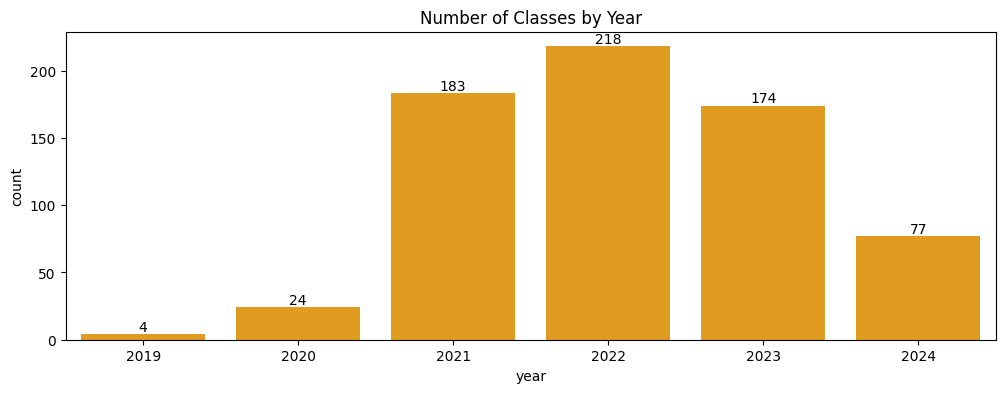

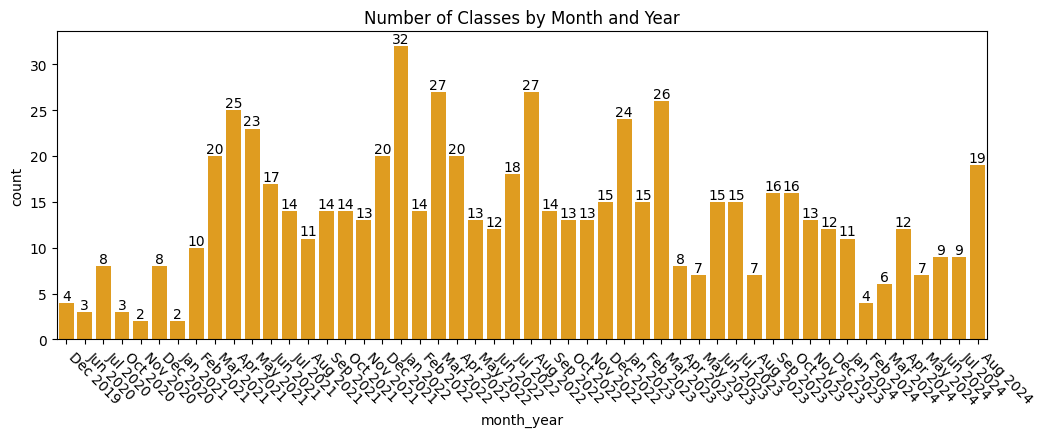

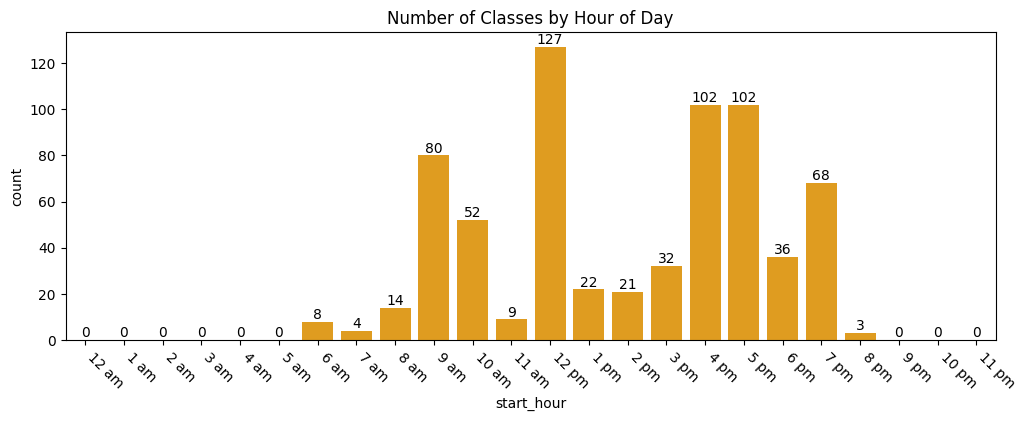

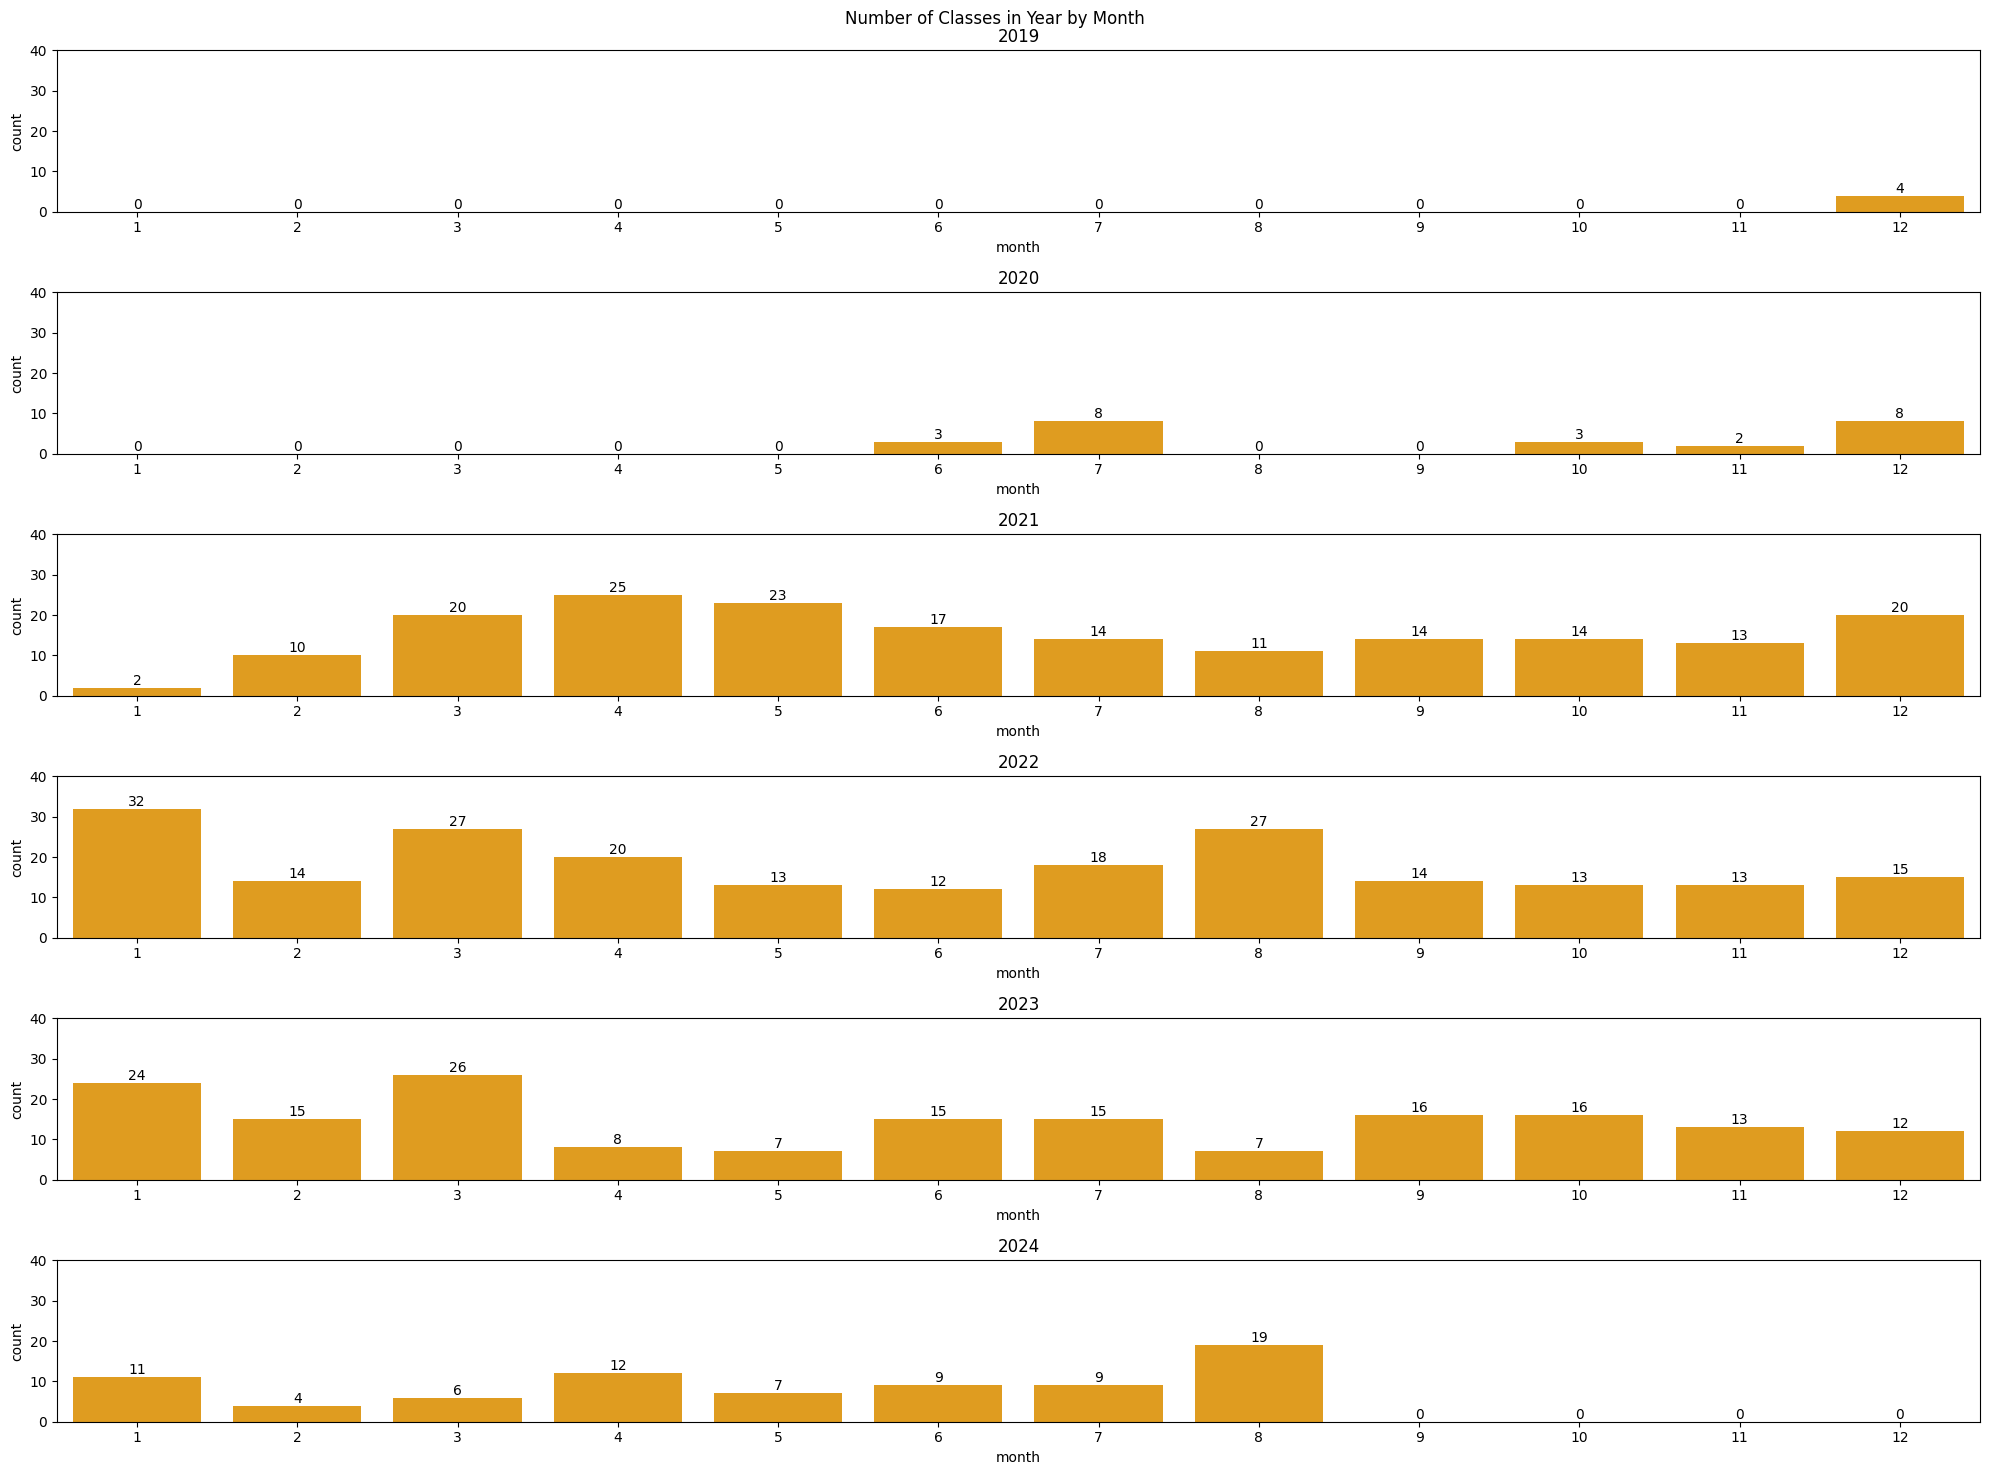

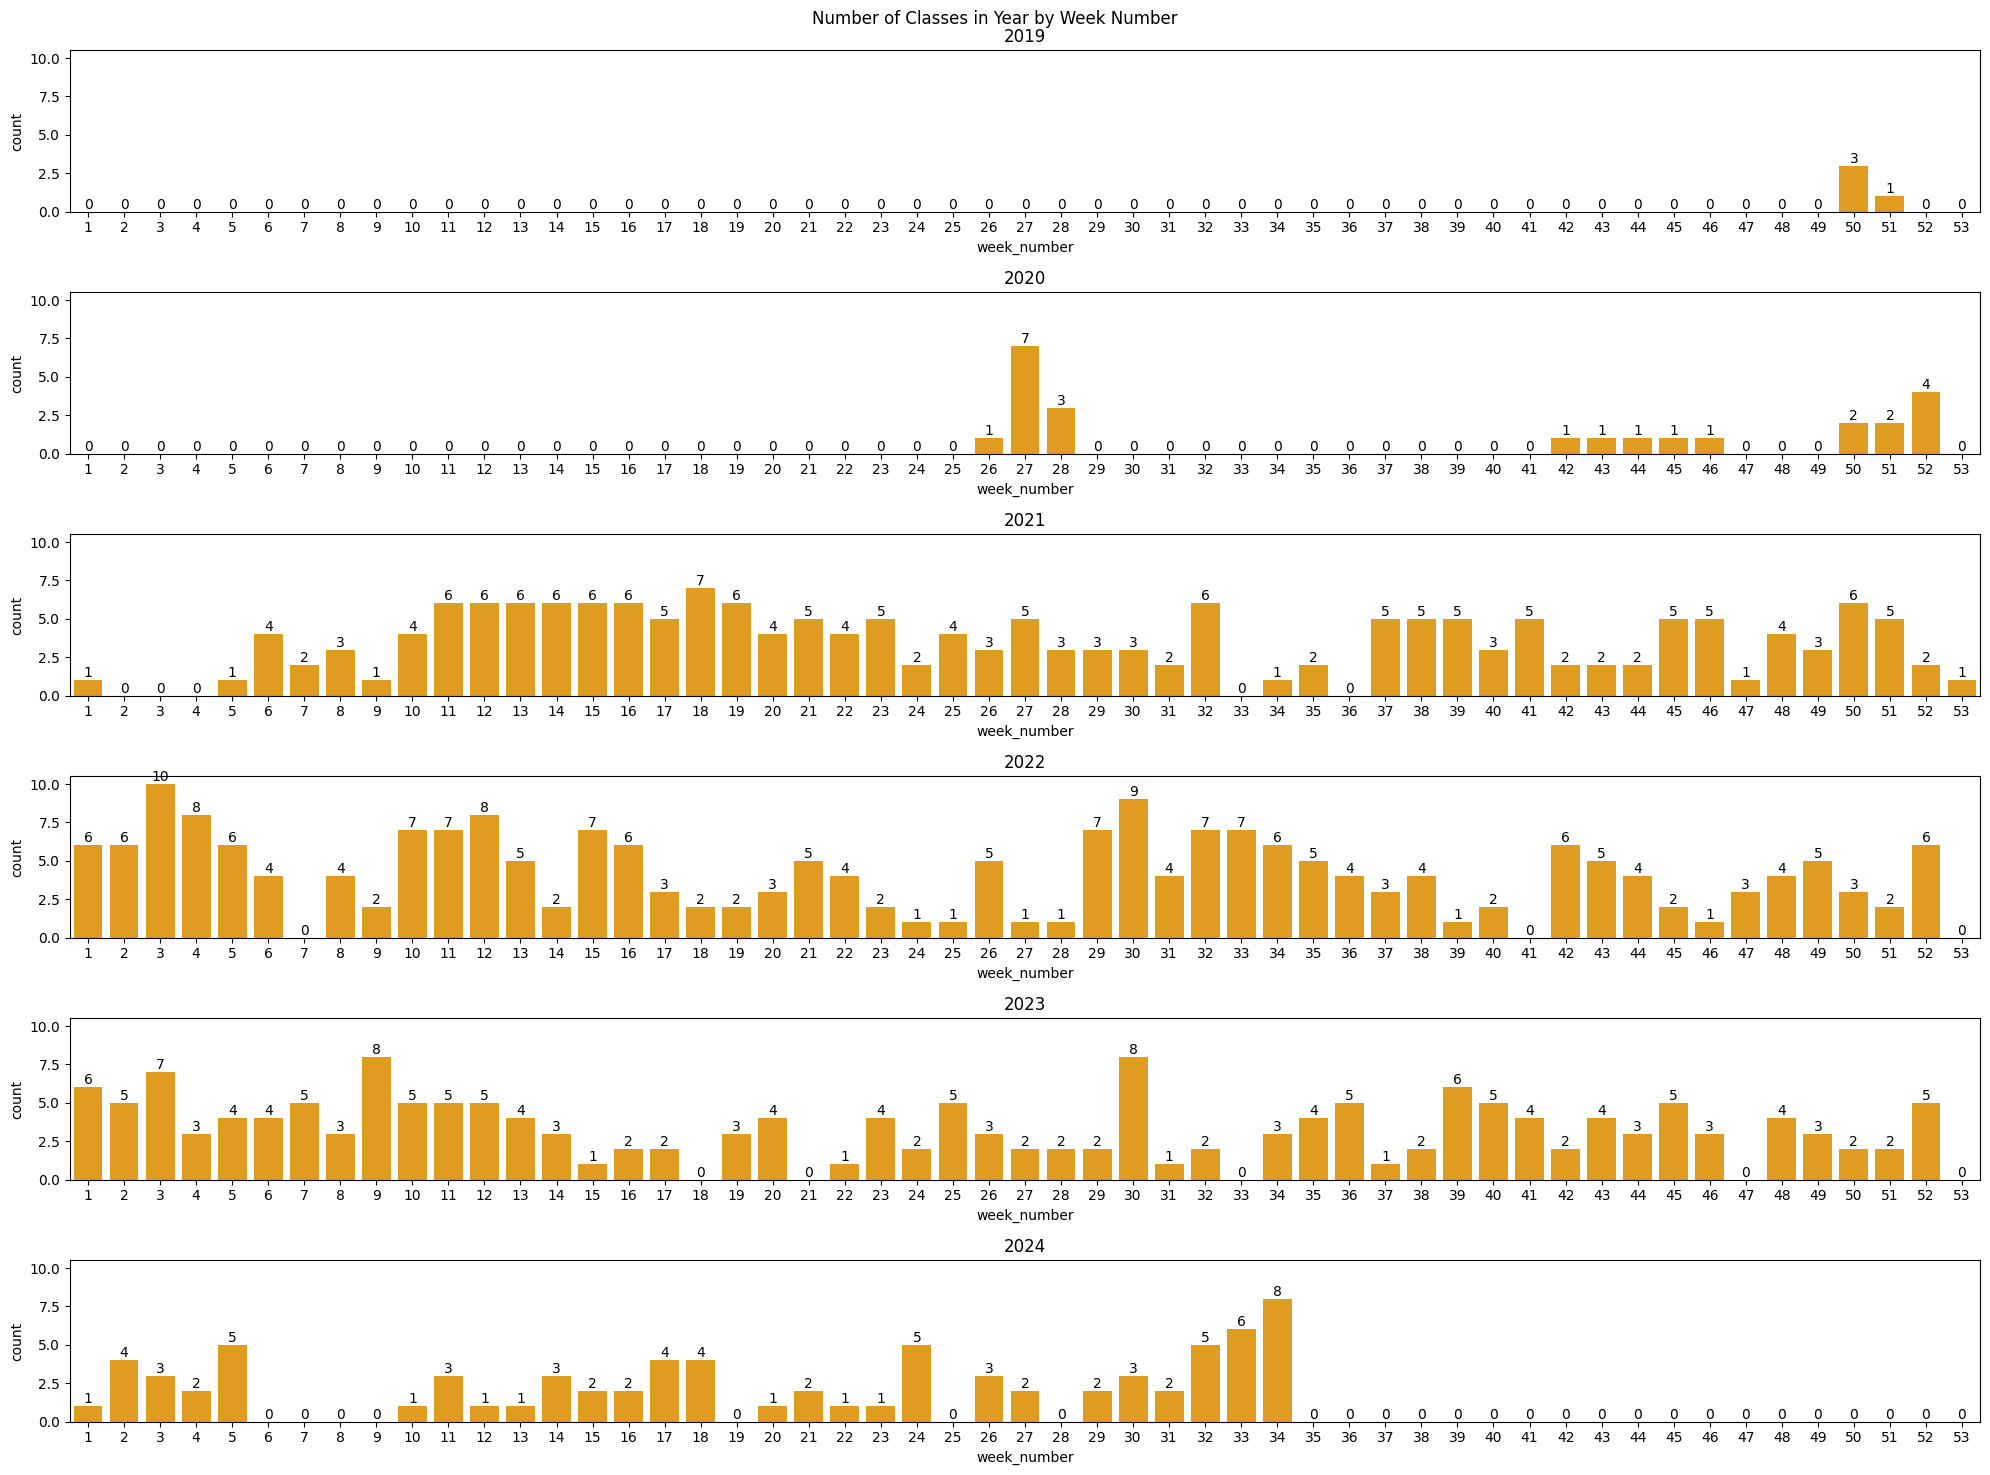

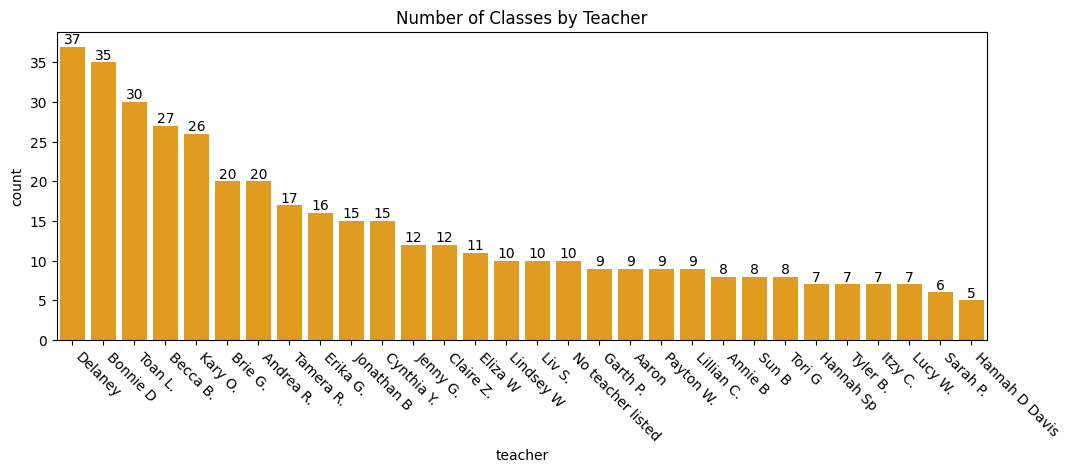

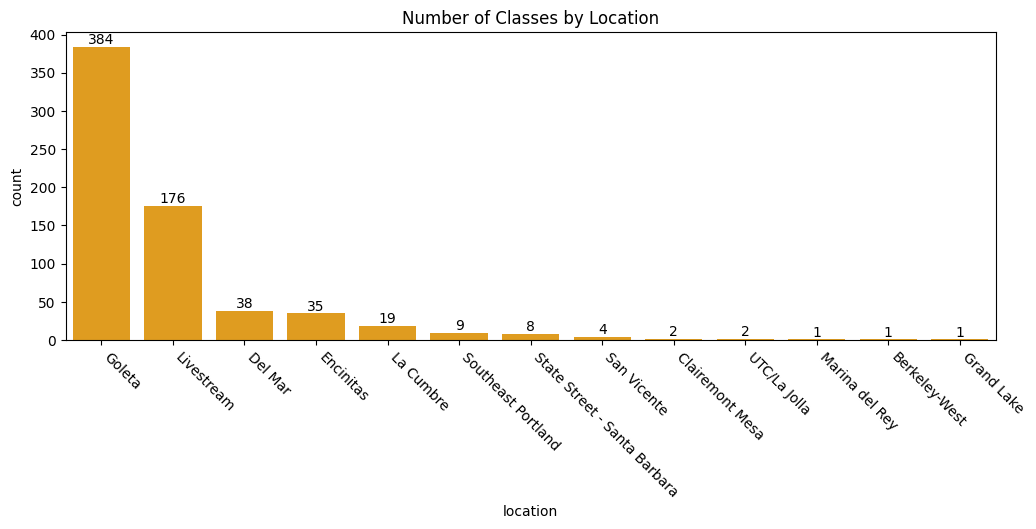

In [6]:
mpl.rcParams['figure.figsize'] = (12, 4)
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.labelsize'] = 'medium'

# by year
fig, ax = plt.subplots()
sns.countplot(x='year', data=class_df, color='orange', ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.title('Number of Classes by Year')

# by year and month
fig, ax = plt.subplots()
sns.countplot(x='month_year', data=class_df, color='orange', ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=-45, ha='left')
plt.title('Number of Classes by Month and Year')

# by time of day
hours = [12] + list(range(1, 12)) + [12] + list(range(1, 12))
for i in range(12):
    hours[i] = str(hours[i]) + ' am'
    
for i in range(12, 24):
    hours[i] = str(hours[i]) + ' pm'
    
fig, ax = plt.subplots()
sns.countplot(x='start_hour', data=class_df, color='orange', order = hours, ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=-45, ha='left')
plt.title('Number of Classes by Hour of Day')


# by year and month, separated by year
years = np.unique(class_df['year'])
n = len(years)
fig, axs = plt.subplots(n, sharex=True, sharey=True, figsize=(20,15))
plt.setp(axs, xticks=range(1, 13), xticklabels=range(1, 13), visible=True, ylim=(0,40))
fig.suptitle('Number of Classes in Year by Month')

for i, year in enumerate(years):
    curr_year_df = class_df[class_df['year']==year]
    ax = axs[i]
    sns.countplot(x='month', data=curr_year_df, color='orange', order=range(1,13), ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    ax.tick_params(labelbottom=True)
    ax.set_title(f'{year}')
fig.tight_layout()     

# by year and week number, separated by year
fig, axs = plt.subplots(n, sharex=True, sharey=True, figsize=(20,15))
plt.setp(axs, xticks=range(1, 54), xticklabels=range(1, 54), visible=True)
fig.suptitle('Number of Classes in Year by Week Number')

for i, year in enumerate(years):
    curr_year_df = class_df[class_df['year']==year]
    ax = axs[i]
    sns.countplot(x='week_number', data=curr_year_df, color='orange', order=range(1,54), ax=ax)
    for container in ax.containers:
        ax.bar_label(container)
    ax.tick_params(labelbottom=True)
    ax.set_title(f'{year}')
fig.tight_layout()        

# by teacher
top_n = 30
fig, ax = plt.subplots()
sns.countplot(x='teacher', data=class_df, color='orange', order=class_df['teacher'].value_counts().iloc[:top_n].index, ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=-45, ha='left')
plt.title('Number of Classes by Teacher')

# by location
fig, ax = plt.subplots()
sns.countplot(x='location', data=class_df, color='orange', order=class_df['location'].value_counts().index, ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=-45, ha='left')
plt.title('Number of Classes by Location');